# <span style="color:#5271FF;">Імпорт бібліотек</span>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy import stats
import numpy as np

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold

import warnings

# Фільтрувати всі warnings
warnings.filterwarnings('ignore')

# <span style="color:#5271FF;">Завантаження даних</span>

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

# <span style="color:#5271FF;">EDA</span>

### <span style="color:#FFD230;">Дослідження розмірності даних</span>

In [3]:
print(f'Train shape: {train_df.shape}')
train_df.head()

Train shape: (378428, 13)


,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,NCU06,17.60,Low Fat,0.024795,Household,231.1010,OUT017,2007,Medium,Tier 2,Supermarket Type1,1760.43266
1,1,FDY26,20.50,Regular,0.102226,Dairy,212.6244,OUT017,2007,Medium,Tier 2,Supermarket Type1,101.20160
2,2,FDK21,18.35,Low Fat,0.092238,Snack Foods,250.1092,OUT013,1987,High,Tier 3,Supermarket Type1,2042.61550
3,3,NCN05,12.15,Low Fat,0.043942,Health and Hygiene,182.2950,OUT049,1999,Medium,Tier 1,Supermarket Type1,3103.95960
4,4,FDA47,10.50,Regular,0.042967,Baking Goods,162.4210,OUT035,2004,Small,Tier 2,Supermarket Type1,442.75700


In [4]:
print(f'Test shape: {test_df.shape}')
test_df.head()

Test shape: (252286, 12)


,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,378428,FDP45,15.70,Low Fat,0.074779,Snack Foods,256.1014,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,378429,FDY44,14.15,Regular,0.024821,Fruits and Vegetables,196.4110,OUT017,2007,Medium,Tier 2,Supermarket Type1
2,378430,NCV29,11.80,LF,0.032813,Health and Hygiene,177.6686,OUT013,1987,High,Tier 3,Supermarket Type1
3,378431,FDG53,10.00,Low Fat,0.087646,Frozen Foods,138.6838,OUT017,2007,Medium,Tier 2,Supermarket Type1
4,378432,NCB18,19.60,Low Fat,0.000000,Household,89.7514,OUT049,1999,Medium,Tier 1,Supermarket Type1


<span style="color:#FD5A46;">Видалимо колонки 'id' з датафрейму, але залишилимо їх, як окремі Pandas.Series</span>

In [5]:
train_id = train_df['id']
test_id = test_df['id']

train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

---

### <span style="color:#FFD230;">Дослідження типів ознак</span>

In [6]:
data_info = train_df.dtypes
data_info

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

---

### <span style="color:#FFD230;">Дослідження пропущених даних</span>

In [7]:
missing_values = train_df.isnull().sum()
missing_values

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

---

### <span style="color:#FFD230;">Дослідження унікальності даних</span>

In [8]:
unique_values = train_df.nunique()
unique_values

Item_Identifier               1559
Item_Weight                    717
Item_Fat_Content                 5
Item_Visibility              72327
Item_Type                       16
Item_MRP                     15354
Outlet_Identifier               10
Outlet_Establishment_Year       15
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             9144
dtype: int64

---

### <span style="color:#FFD230;">Дослідження викидів у даних</span>

Number of outliers using IQR method: 15029


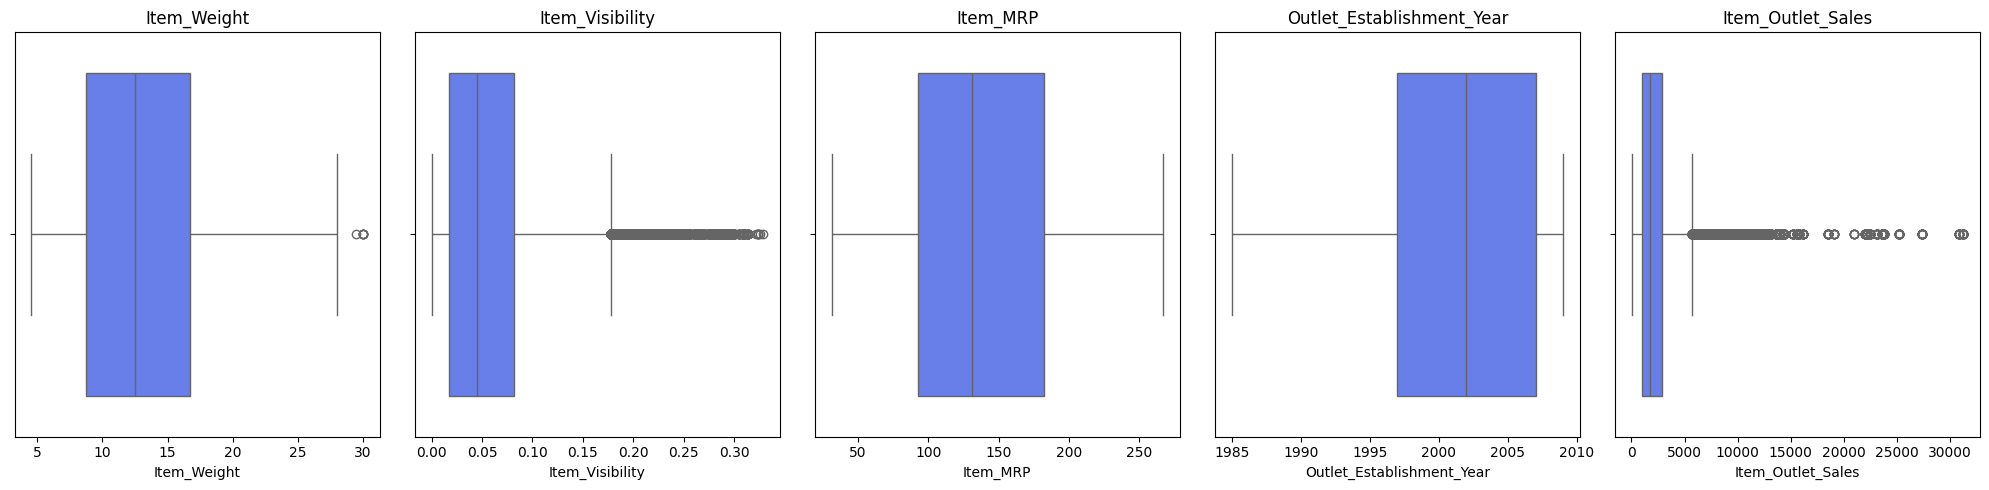

In [9]:
# Функція для виявлення викидів за допомогою IQR
def find_outliers_iqr(df):
    outliers_indices = set()
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_indices.update(df[(df[column] < lower_bound) | (df[column] > upper_bound)].index)
    return outliers_indices

# Знайти викиди
outliers_iqr = find_outliers_iqr(train_df)

# Відобразити кількість викидів
print(f'Number of outliers using IQR method: {len(outliers_iqr)}')

# Візуалізація викидів
num_columns = len(train_df.select_dtypes(include=['float64', 'int64']).columns)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(20, 5))

for ax, column in zip(axes, train_df.select_dtypes(include=['float64', 'int64']).columns):
    sns.boxplot(x=train_df[column], color='#5271FF', ax=ax)
    ax.set_title(f'{column}')

plt.tight_layout()
plt.show()

Number of outliers using Z-score method: 6194


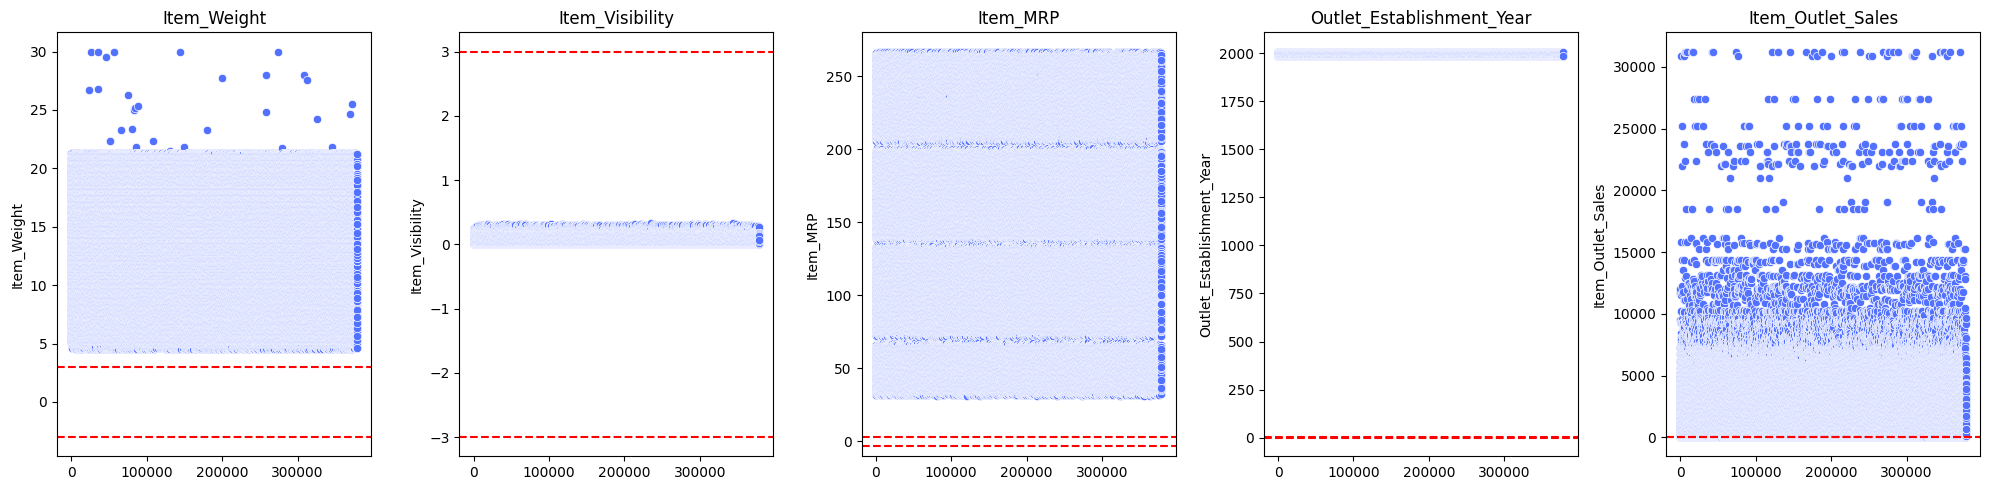

In [10]:
# Функція для виявлення викидів за допомогою Z-оцінки
def find_outliers_z(df, threshold=3):
    outliers_indices = set()
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        z_scores = np.abs(stats.zscore(df[column]))
        outliers_indices.update(df[(z_scores > threshold)].index)
    return outliers_indices

# Знайти викиди
outliers_z = find_outliers_z(train_df)

# Відобразити кількість викидів
print(f'Number of outliers using Z-score method: {len(outliers_z)}')

# Візуалізація викидів
num_columns = len(train_df.select_dtypes(include=['float64', 'int64']).columns)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(20, 5))

for ax, column in zip(axes, train_df.select_dtypes(include=['float64', 'int64']).columns):
    sns.scatterplot(data=train_df, x=range(len(train_df)), y=column, color='#5271FF', ax=ax)
    ax.set_title(f'{column}')
    ax.axhline(y=3, color='red', linestyle='--')
    ax.axhline(y=-3, color='red', linestyle='--')

plt.tight_layout()
plt.show()

<span style="color:#FD5A46;">Видалимо записи, які були ідентифіковані, як викиди</span>

In [11]:
# Знайти викиди за допомогою обох методів
outliers_iqr = find_outliers_iqr(train_df)
outliers_z = find_outliers_z(train_df)

# Об'єднати індекси викидів
combined_outliers = outliers_iqr.union(outliers_z)

# Видалити всі записи, які були ідентифіковані як викиди
train_df_cleaned = train_df.drop(index=combined_outliers).reset_index(drop=True)

# Відобразити кількість видалених записів та розмір очищеного DataFrame
print(f'Кількість виявлених викидів: {len(combined_outliers)}')
print(f'Розмірність очищеного DataFrame: {train_df_cleaned.shape}')

Кількість виявлених викидів: 15034
Розмірність очищеного DataFrame: (363394, 12)


---

### <span style="color:#FFD230;">Дослідження розподілу цільової змінної</span>

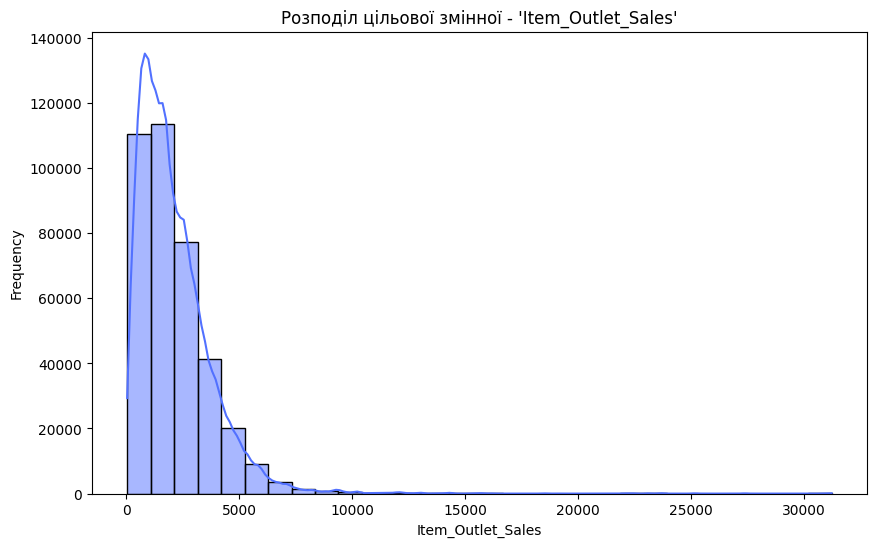

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Item_Outlet_Sales'], bins=30, kde=True, color='#5271FF')
plt.title('Розподіл цільової змінної - \'Item_Outlet_Sales\'')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Frequency')
plt.show()

---

### <span style="color:#FFD230;">Дослідження кореліцій між змінними</span>

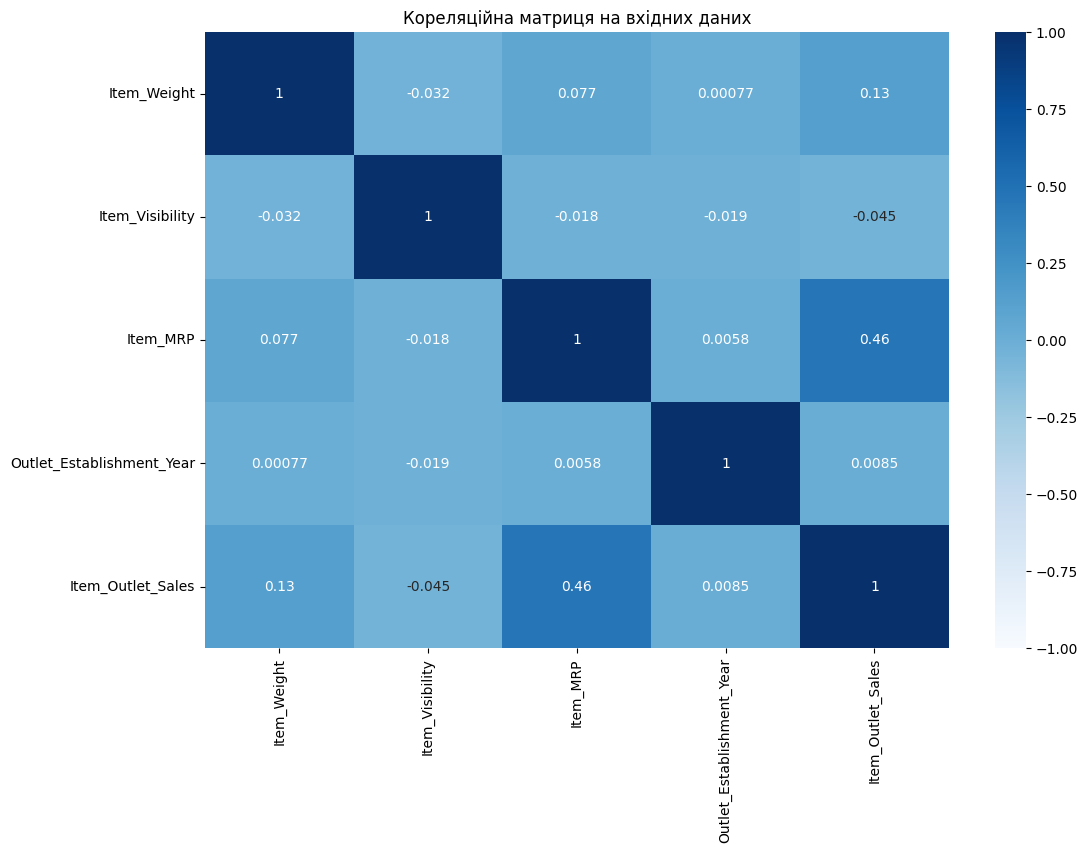

In [13]:
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Кореляційна матриця на вхідних даних')
plt.show()

# <span style="color:#5271FF;">Передобробка даних</span>

### <span style="color:#FFD230;">Перекодування ознак</span>

In [14]:
def encode_data(df):
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

    label_encoder = LabelEncoder()
    df['Item_Fat_Content'] = label_encoder.fit_transform(df['Item_Fat_Content'])

    outlet_identifier_mapping = {'OUT017': 0, 'OUT013': 1, 'OUT049': 2, 'OUT035': 3, 'OUT045': 4, 
                                 'OUT018': 5, 'OUT046': 6, 'OUT010': 7, 'OUT019': 8, 'OUT027': 9}
    df['Outlet_Identifier'] = df['Outlet_Identifier'].map(outlet_identifier_mapping)

    outlet_size_mapping = {'Small': 0, 'Medium': 1, 'High': 2}
    df['Outlet_Size'] = df['Outlet_Size'].map(outlet_size_mapping)

    outlet_location_type_mapping = {'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
    df['Outlet_Location_Type'] = df['Outlet_Location_Type'].map(outlet_location_type_mapping)

    outlet_type_mapping = {'Grocery Store': 0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}
    df['Outlet_Type'] = df['Outlet_Type'].map(outlet_type_mapping)

    df_encoded = pd.get_dummies(df, columns=['Item_Identifier', 'Item_Type'])
    
    return df_encoded


train_df = encode_data(train_df)
test_df = encode_data(test_df)

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (378428, 1585)
Test shape: (252286, 1584)


---

### <span style="color:#FFD230;">Нормалізація даних</span>

In [15]:
scaler = MinMaxScaler()

numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
features = train_df[numeric_cols].drop(columns=['Item_Outlet_Sales'])
target = train_df['Item_Outlet_Sales']

# Нормалізовуємо дані
features_normalized = scaler.fit_transform(features)
features_normalized_df = pd.DataFrame(features_normalized, columns=features.columns)

# Додаємо назад цільову змінну
train_df = pd.concat([features_normalized_df, train_df.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)
train_df = pd.concat([train_df, target.reset_index(drop=True)], axis=1)

# Нормалізуємо тестові дані
test_df = scaler.fit_transform(test_df)



# scaler = MinMaxScaler()

# numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
# features = train_df[numeric_cols].drop(columns=['Item_Outlet_Sales'])
# target = train_df['Item_Outlet_Sales']

# # Нормалізовуємо дані
# features_normalized = scaler.fit_transform(features)

# # Використання PCA для зменшення розмірності
# pca = PCA(n_components=0.95)  # збереження 95% дисперсії
# features_pca = pca.fit_transform(features_normalized)

# # Перетворити PCA дані назад у DataFrame
# features_pca_df = pd.DataFrame(features_pca)

# # Об'єднання PCA даних з іншими категоріальними даними
# train_df = pd.concat([features_pca_df, train_df.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)

# print(f'Train shape: {train_df.shape}')

# <span style="color:#5271FF;">Створення та навчання моделей</span>

### <span style="color:#FFD230;">Ініціалізація моделей</span>

In [16]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)

estimators = [('xgb', xgb_model), 
              ('lgb', lgb_model), 
              ('gbr', gbr_model)]

stacking_model = StackingRegressor(estimators=estimators,
                                   final_estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42))

---

### <span style="color:#FFD230;">Крос-валідація</span>

In [18]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Оцінка моделей за допомогою крос-валідації
def rmsle_cv(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_log_error')
    rmsle_scores = np.sqrt(-scores)
    return rmsle_scores

# Оцінка окремих моделей
xgb_scores = rmsle_cv(xgb_model, train_df.drop(columns=['Item_Outlet_Sales']), target, kf)
lgb_scores = rmsle_cv(lgb_model, train_df.drop(columns=['Item_Outlet_Sales']), target, kf)
gbr_scores = rmsle_cv(gbr_model, train_df.drop(columns=['Item_Outlet_Sales']), target, kf)

# Оцінка стейкінг моделі
stacking_scores = rmsle_cv(stacking_model, train_df.drop(columns=['Item_Outlet_Sales']), target, kf)

# Виведення середніх та стандартних відхилень оцінок
print(f'XGBoost Mean RMSLE:  \t{np.mean(xgb_scores):.2f}  |  Std: {np.std(xgb_scores)}')
print(f'LightGBM Mean RMSLE: \t{np.mean(lgb_scores):.2f}  |  Std: {np.std(lgb_scores)}')
print(f'Gradient Boosting Mean RMSLE: \t{np.mean(gbr_scores):.2f}, Std: {np.std(gbr_scores)}')
print(f'Stacking Mean RMSLE: \t{np.mean(stacking_scores):.2f}  |  Std: {np.std(stacking_scores)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3936
[LightGBM] [Info] Number of data points in the train set: 189214, number of used features: 1584
[LightGBM] [Info] Start training from score 2125.591706
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3940
[LightGBM] [Info] Number of data points in the train set: 189214, number of used features: 1584
[LightGBM] [Info] Start training from score 2124.526027
[LightGBM] [Warn

---

### <span style="color:#FFD230;">Візуалізація оцінок моделей</span>

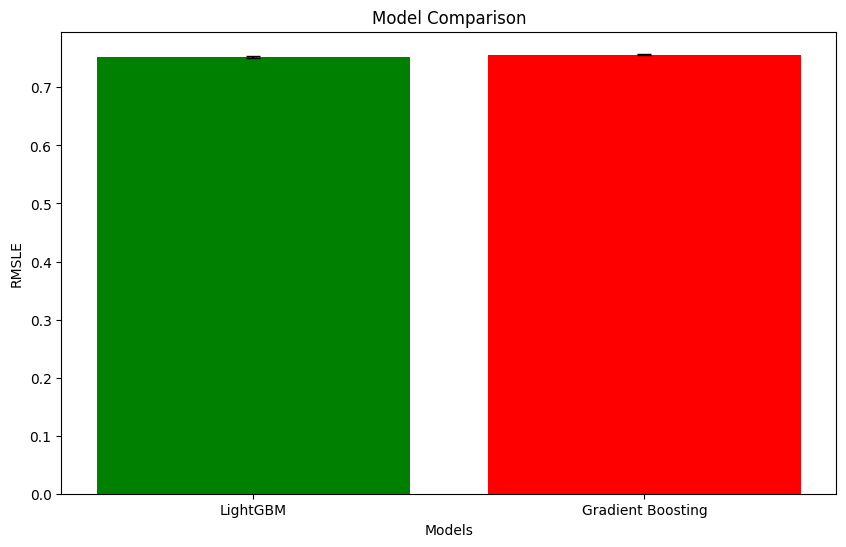

In [19]:
models = ['XGBoost', 'LightGBM', 'Gradient Boosting', 'Stacking']
mean_scores = [np.mean(xgb_scores), np.mean(lgb_scores), np.mean(gbr_scores), np.mean(stacking_scores)]
std_scores = [np.std(xgb_scores), np.std(lgb_scores), np.std(gbr_scores), np.std(stacking_scores)]

plt.figure(figsize=(10, 6))
plt.bar(models, mean_scores, yerr=std_scores, capsize=5, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('RMSLE')
plt.title('Model Comparison')
plt.show()

---

### <span style="color:#FFD230;">Навчання стейкінг моделі на всьому наборі даних</span>

In [ ]:
stacking_model.fit(train_df.drop(columns=['Item_Outlet_Sales']), target)

# Прогнозування
predictions = stacking_model.predict(test_df)

# Створення файлу сабмішена
submission = sample_submission_df.copy()
submission['Item_Outlet_Sales'] = predictions

# Збереження сабмішена у файл
submission.to_csv('data\\submission.csv', index=False)
print("Submission file created.")


### Доробити

In [ ]:
# import joblib

# # Збереження кожної моделі у файл
# joblib.dump(ridge_model_full_data, 'ridge_model_full_data.pkl')
# joblib.dump(svr_model_full_data, 'svr_model_full_data.pkl')
# joblib.dump(gbr_model_full_data, 'gbr_model_full_data.pkl')
# joblib.dump(xgb_model_full_data, 'xgb_model_full_data.pkl')
# joblib.dump(lgb_model_full_data, 'lgb_model_full_data.pkl')
# joblib.dump(rf_model_full_data, 'rf_model_full_data.pkl')
# joblib.dump(stack_gen_model, 'stack_gen_model.pkl')